In [1]:
import os
import sys

# Set PYTHONPATH
pythonpath_parts = [
    "/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study",
    "/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/cell_observatory_platform",
    "/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/monai",
]
existing_pythonpath = os.environ.get("PYTHONPATH", "")
if existing_pythonpath:
    pythonpath_parts.append(existing_pythonpath)

os.environ["PYTHONPATH"] = ":".join(pythonpath_parts)

# Add paths to sys.path if not already present
for path in pythonpath_parts:
    if path not in sys.path:
        sys.path.insert(0, path)

# Change working directory
os.chdir("/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study")

print(f"PYTHONPATH set to: {os.environ['PYTHONPATH']}")
print(f"Current directory: {os.getcwd()}")
print(f"sys.path includes: {sys.path[:3]}...")


PYTHONPATH set to: /clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study:/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/cell_observatory_platform:/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/monai
Current directory: /clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study
sys.path includes: ['/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/monai', '/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study/cell_observatory_platform', '/clusterfs/nvme/martinalvarez/GitHub/segmentation_case_study']...


In [2]:
from cell_observatory_finetune.data.utils import instance_map_to_boundary
from zarr import open_array
from pathlib import Path

data_dir = Path("/clusterfs/vast/forsynthetic/benchmark_tests/data/synthetic_data_iteration_1/")
specific_data = Path("20250131_mem_histone/fish1_24hpf_mYH/roi2_mb/000x_000y_000z.zarr")


test_data = open_array(
    data_dir / specific_data,
    mode="r",
)
test_data.shape


/clusterfs/nvme/martinalvarez/miniforge3/envs/segproj/lib/python3.12/site-packages/numcodecs/__init__.py:106: DeprecationWarning: crc32c usage is deprecated since numcodecs v0.16.4. It is recommended to install google_crc32c instead.
  from numcodecs.checksum32 import CRC32, Adler32, JenkinsLookup3


(1, 256, 1024, 1664, 2)

In [3]:
import torch
import numpy as np

loaded_data = torch.Tensor(np.array(test_data[:]))

In [7]:
# instance map to boundary expects N, Z, Y, X
# Last channel is the instance map
instance_map = loaded_data[:, :, :, :, -1]
syn_data = loaded_data[:, :, :, :, 0]

boundary_map = instance_map_to_boundary(instance_map)



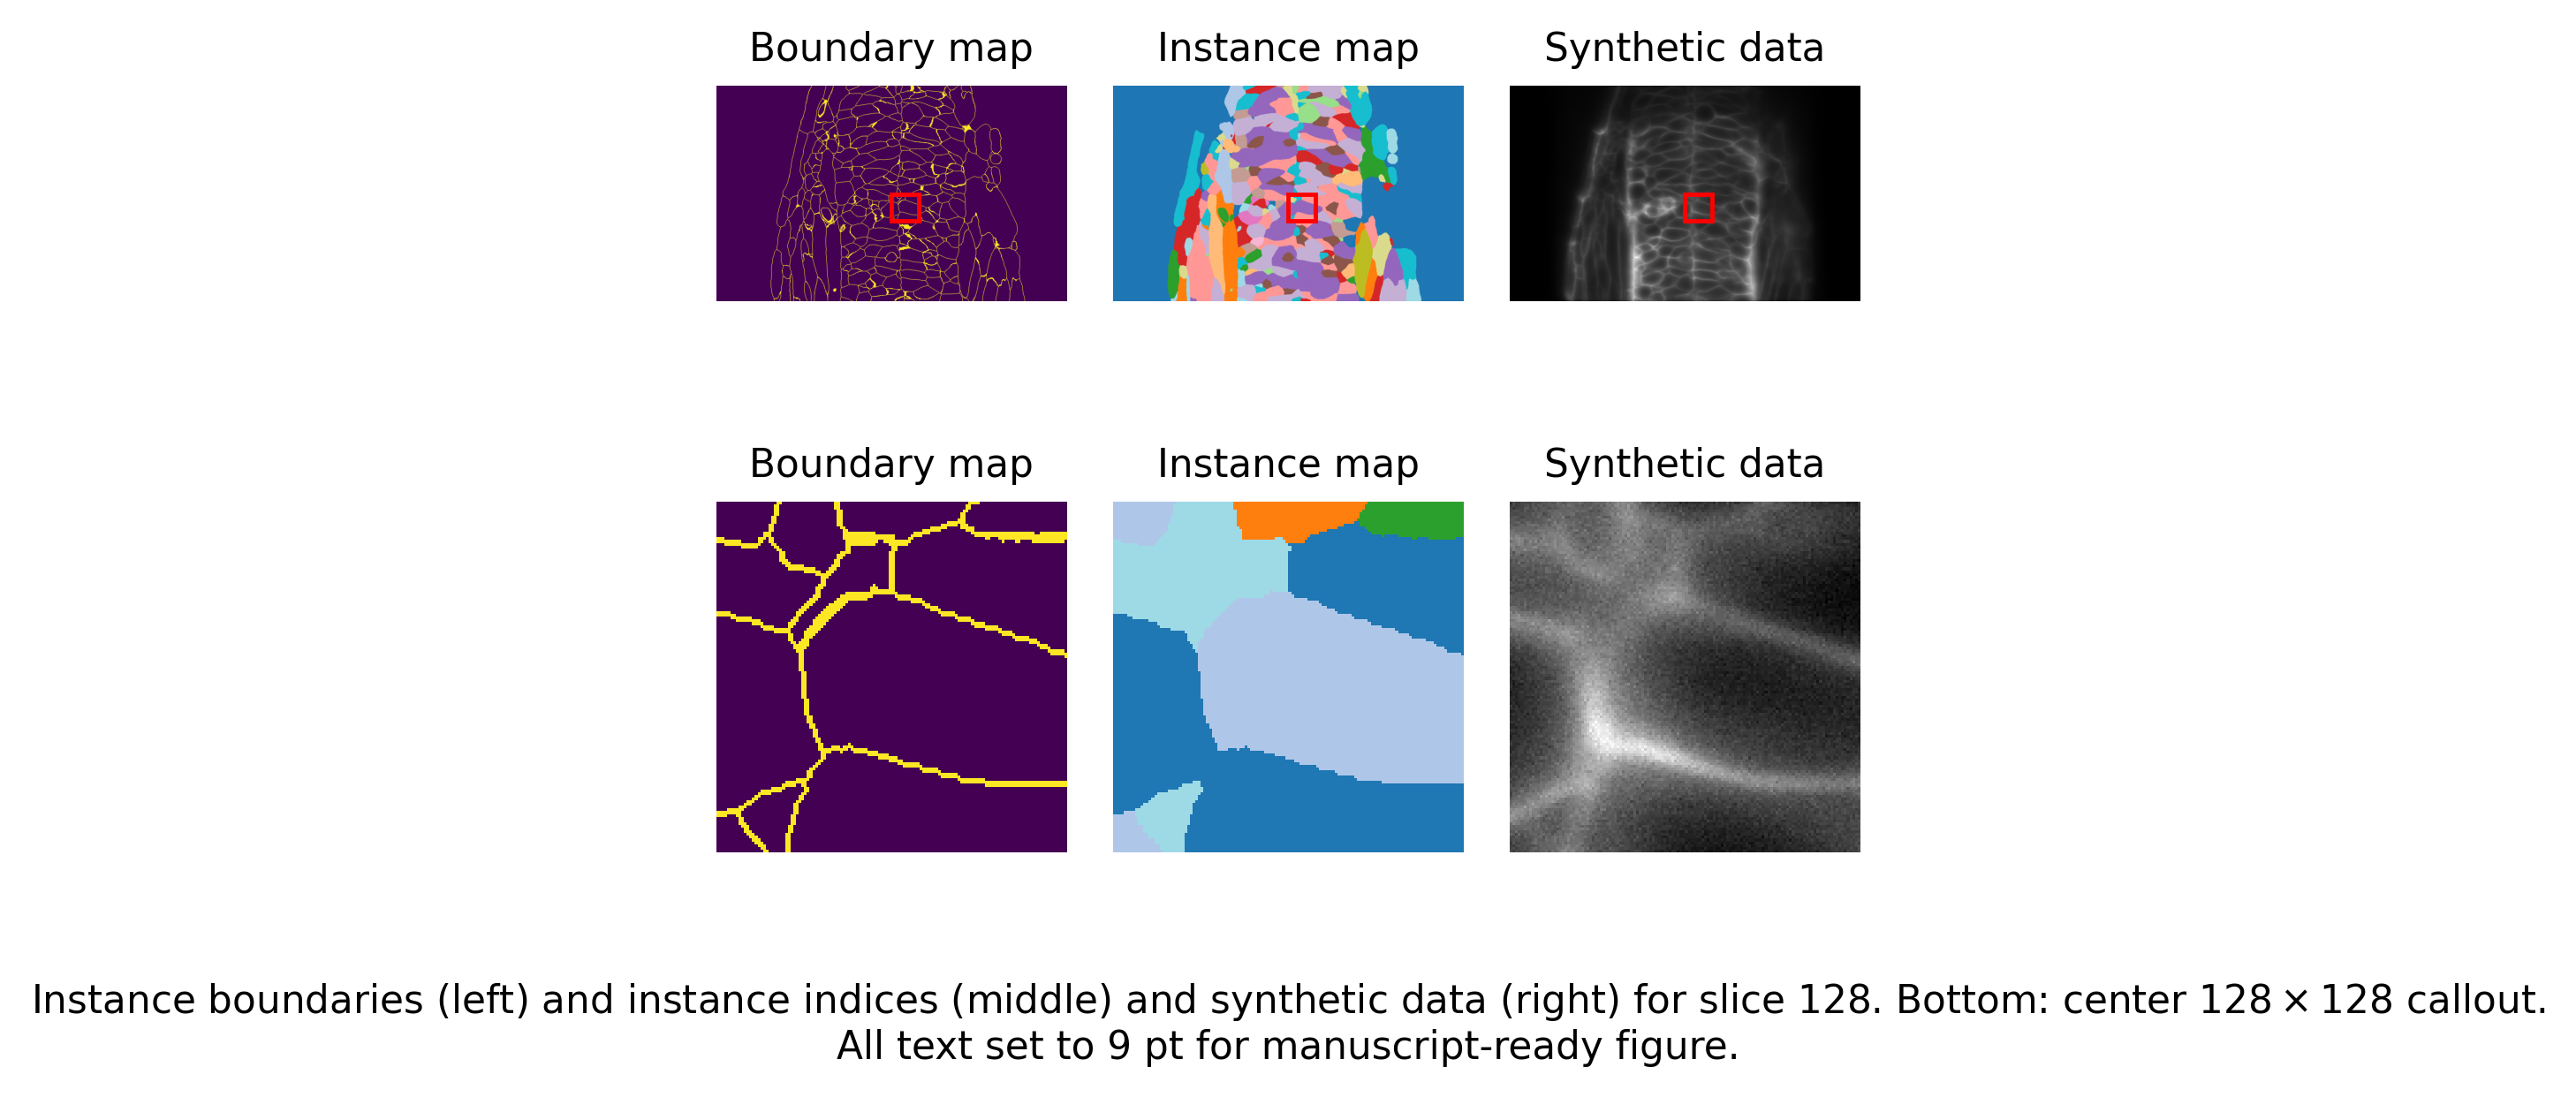

In [11]:
# Visualize a 1x128x128 boundary map and the corresponding instance map
import matplotlib.pyplot as plt

import matplotlib.patches as patches

fig, axs = plt.subplots(
    2, 3, 
    figsize=(4, 4),
    dpi=350
)

# Top row: entire slices at depth 128
im_top0 = axs[0, 0].imshow(boundary_map[0, 128, :, :], cmap="viridis")
axs[0, 0].set_title("Boundary map", fontsize=9)
im_top1 = axs[0, 1].imshow(instance_map[0, 128, :, :], cmap="tab20")
axs[0, 1].set_title("Instance map", fontsize=9)
im_top2 = axs[0, 2].imshow(syn_data[0, 128, :, :], cmap="gray")
axs[0, 2].set_title("Synthetic data", fontsize=9)

# Bottom row: zoomed callout (center 128x128), with rectangle on top marking callout region
crop_size = 128
centerx = boundary_map.shape[3] // 2
centery = boundary_map.shape[2] // 2
x0 = centerx
y0 = centery
x1 = x0 + crop_size
y1 = y0 + crop_size

im_bot0 = axs[1, 0].imshow(boundary_map[0, 128, y0:y1, x0:x1], cmap="viridis")
axs[1, 0].set_title("Boundary map", fontsize=9)
im_bot1 = axs[1, 1].imshow(instance_map[0, 128, y0:y1, x0:x1], cmap="tab20")
axs[1, 1].set_title("Instance map", fontsize=9)
im_bot2 = axs[1, 2].imshow(syn_data[0, 128, y0:y1, x0:x1], cmap="gray")
axs[1, 2].set_title("Synthetic data", fontsize=9)

# Draw callout rectangle on top figures in red
for col in range(3):
    rect = patches.Rectangle(
        (x0, y0), crop_size, crop_size,
        linewidth=1, edgecolor='red', facecolor='none'
    )
    axs[0, col].add_patch(rect)

for ax in axs.flat:
    ax.axis("off")
    ax.title.set_fontsize(9)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(9)

# Add a compact caption below
fig.text(0.5, 0.02,
         'Instance boundaries (left) and instance indices (middle) and synthetic data (right) for slice 128. Bottom: center $128\\times128$ callout.\n'
         'All text set to 9 pt for manuscript-ready figure.',
         ha='center', va='bottom', fontsize=9)

plt.tight_layout(rect=[0,0.06,1,1])

plt.show()